In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

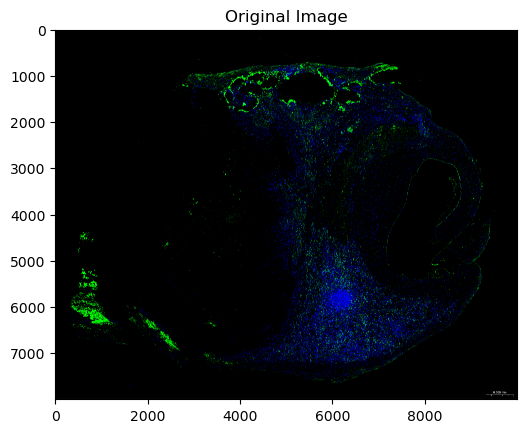

In [51]:
#################### Show Original Image ####################
image = cv2.imread('example.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image") 
plt.show()

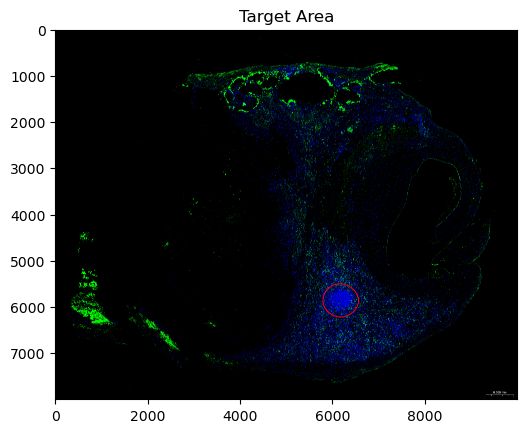

In [52]:
#################### Show Target Area ####################
image = cv2.imread('example_target.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Target Area") 
plt.show()

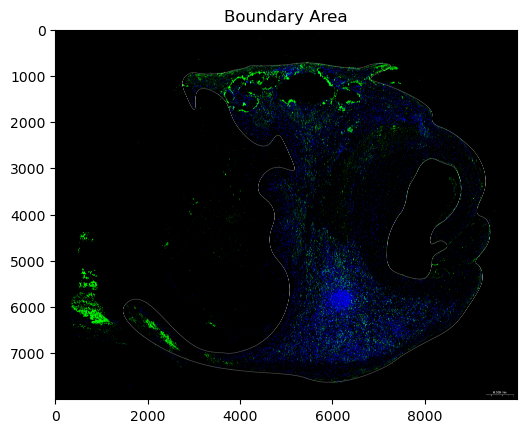

In [53]:
#################### Show Boundary Area ####################
image = cv2.imread('example_boundary.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Boundary Area") 
plt.show()

In [54]:
#################### Find Target Contour ####################
# Load the image
image = cv2.imread('example_target.jpg')

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the HSV range for red color
lower_red = np.array([0, 50, 50])
upper_red = np.array([10, 255, 255])
mask = cv2.inRange(hsv, lower_red, upper_red)

# Perform morphological operations to remove noise
kernel = np.ones((5, 5), np.uint8)
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Detect contours
contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest elliptical contour
max_area = 0
max_contour = None
for contour in contours:
    area = cv2.contourArea(contour)
    if area > max_area:
        max_area = area
        max_contour = contour

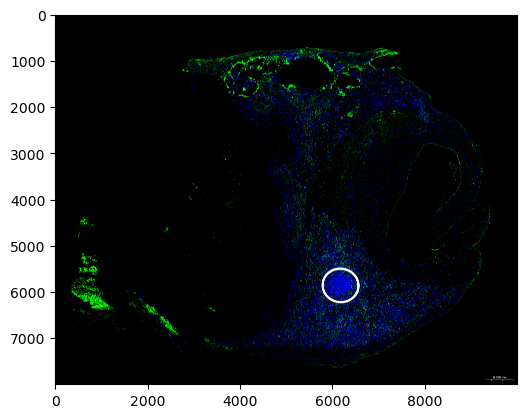

In [55]:
##################### Confirm Found Ellipse Contour #####################
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw the largest ellipse contour on the image
if max_contour is not None:
    ellipse = cv2.fitEllipse(max_contour)
    center = (int(ellipse[0][0]), int(ellipse[0][1]))
    cv2.ellipse(image, ellipse, (255, 255, 255), 50)

# Adjust the y-axis to fit matplotlib's coordinate system
h, w, _ = image.shape
plt.gca().invert_yaxis()
plt.imshow(image)  # Display the image using matplotlib

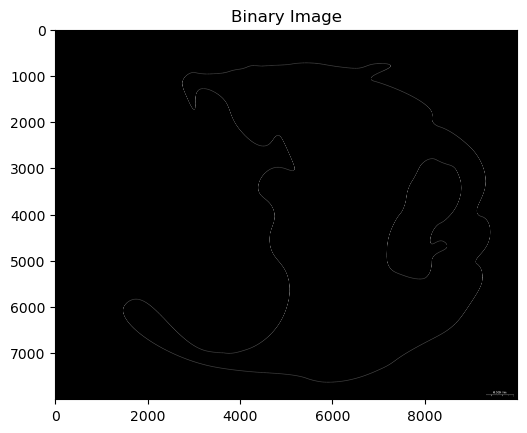

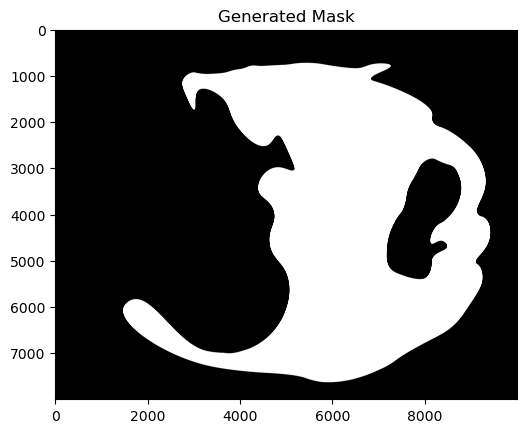

True

In [56]:
#################### Generate Drawable Boundary ####################

# Load the boundary image
image_path = "example_boundary.jpg"
image = cv2.imread(image_path)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold to extract white regions
_, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

# Display the binary result
plt.imshow(binary, cmap='gray')
plt.title("Binary Image")
plt.show()

# Perform morphological closing to fill holes
kernel = np.ones((5, 5), np.uint8)
processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# Find contours and hierarchy using cv2.RETR_TREE
contours, _ = cv2.findContours(processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank mask
mask = np.zeros_like(gray)

# Sort contours by area and calculate their properties
contour_info = []
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    M = cv2.moments(contour)
    if M["m00"] != 0:  # Avoid division by zero
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        contour_info.append({"index": i, "area": area, "center": (cx, cy), "contour": contour})

# Sort contours by descending area
contour_info = sorted(contour_info, key=lambda x: x["area"], reverse=True)

# The largest contour is the outer boundary
outer_contour = contour_info[0]["contour"]
cv2.drawContours(mask, [outer_contour], -1, 1, thickness=cv2.FILLED)

# Outer contour center
outer_center = contour_info[0]["center"]

# Process inner contours
for info in contour_info[1:]:
    # Calculate the distance between inner and outer contour centers
    cx, cy = info["center"]
    distance = np.sqrt((cx - outer_center[0]) ** 2 + (cy - outer_center[1]) ** 2)

    # If the area is smaller and the distance is large, classify as an inner contour
    if info["area"] < contour_info[0]["area"] * 0.5 and distance > 50:
        cv2.drawContours(mask, [info["contour"]], -1, 0, thickness=cv2.FILLED)  # Remove inner contour

# Display the final mask
plt.imshow(mask, cmap='gray')
plt.title("Generated Mask")
plt.show()

# Save the final mask
cv2.imwrite('final_generated_mask.png', mask * 255)

In [57]:
#################### Validate Generated Ellipses ####################
# Function to check if a new ellipse overlaps with existing ellipses
def is_overlapping(new_ellipse, existing_ellipses, mask_shape):
    """Check if the new ellipse overlaps with existing ellipses using masks."""
    temp_mask = np.zeros(mask_shape, dtype=np.uint8)
    for ellipse in existing_ellipses:
        cv2.ellipse(temp_mask, ellipse, 255, thickness=-1)
    test_mask = np.zeros(mask_shape, dtype=np.uint8)
    cv2.ellipse(test_mask, new_ellipse, 255, thickness=-1)
    overlap = cv2.bitwise_and(temp_mask, test_mask)
    return np.any(overlap > 0)

# Function to check if the ellipse is fully inside the mask
def is_ellipse_in_mask(center, axes, angle, mask, num_points=16):
    """Check if the ellipse is fully inside the valid region of the mask."""
    cx, cy = center
    major_axis, minor_axis = axes
    theta = np.radians(angle)
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    ellipse_points = [
        (
            int(cx + (major_axis / 2) * np.cos(a) * np.cos(theta) - (minor_axis / 2) * np.sin(a) * np.sin(theta)),
            int(cy + (major_axis / 2) * np.cos(a) * np.sin(theta) + (minor_axis / 2) * np.sin(a) * np.cos(theta))
        )
        for a in angles
    ]
    for px, py in ellipse_points:
        if px < 0 or px >= mask.shape[1] or py < 0 or py >= mask.shape[0]:
            return False
        if mask[py, px] == 0:
            return False
    return True

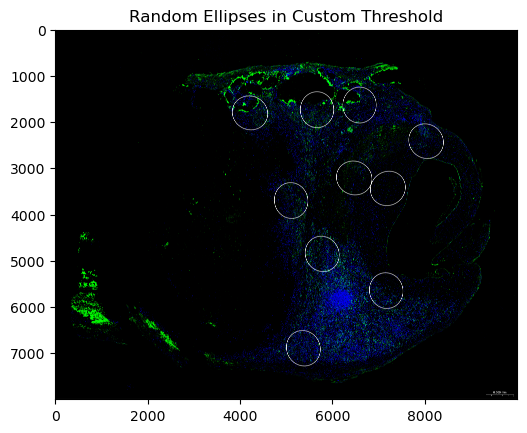

True

In [58]:
################ Generate random non-overlapping ellipses ################
num_random_ellipses = 10
existing_ellipses = [ellipse]
image = cv2.imread('example.jpg')

for _ in range(num_random_ellipses):
    while True:
        height, width = image.shape[:2]
        random_center = (random.randint(0, width), random.randint(0, height))
        random_angle = random.uniform(0, 180)
        fixed_axes = ellipse[1]

        if is_ellipse_in_mask(random_center, fixed_axes, random_angle, mask, num_points=32):
            if not is_overlapping((random_center, fixed_axes, random_angle), existing_ellipses, mask.shape):
                random_ellipse = (random_center, fixed_axes, random_angle)
                existing_ellipses.append(random_ellipse)
                cv2.ellipse(image, random_ellipse, (255, 255, 255), 10)
                break

# Display the final result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Random Ellipses in Custom Threshold")
plt.show()

# Save the final result
cv2.imwrite('final_output.png', image)